In [6]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision  # 数据库模块
import matplotlib.pyplot as plt
# torch.manual_seed(1)  # reproducible
EPOCH = 1  # 训练整批数据次数，训练次数越多，精度越高，为了演示，我们训练5次
BATCH_SIZE = 50  # 每次训练的数据集个数
LR = 0.001  # 学习效率
DOWNLOAD_MNIST = True  # 如果你已经下载好了EMNIST数据就设置 False

# EMNIST 手写字母 训练集
train_data = torchvision.datasets.EMNIST(
    root='./data',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download = DOWNLOAD_MNIST,
    split = 'letters'
)
# EMNIST 手写字母 测试集
test_data = torchvision.datasets.EMNIST(
    root='./data',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=False,
    split = 'letters'
)
# 批训练 50samples, 1 channel, 28x28 (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
# 每一步 loader 释放50个数据用来学习
# 为了演示, 我们测试时提取2000个数据先
# shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_x = torch.unsqueeze(test_data.data, dim=1).type(torch.FloatTensor)[:2000] / 255.
test_y = test_data.targets[:2000]
#test_x = test_x.cuda() # 若有cuda环境，取消注释
#test_y = test_y.cuda() # 若有cuda环境，取消注释

100%|██████████| 562M/562M [00:56<00:00, 10.0MB/s] 


Extracting ./data\EMNIST\raw\gzip.zip to ./data\EMNIST\raw


6
16
9
16
8
10
20
25
13


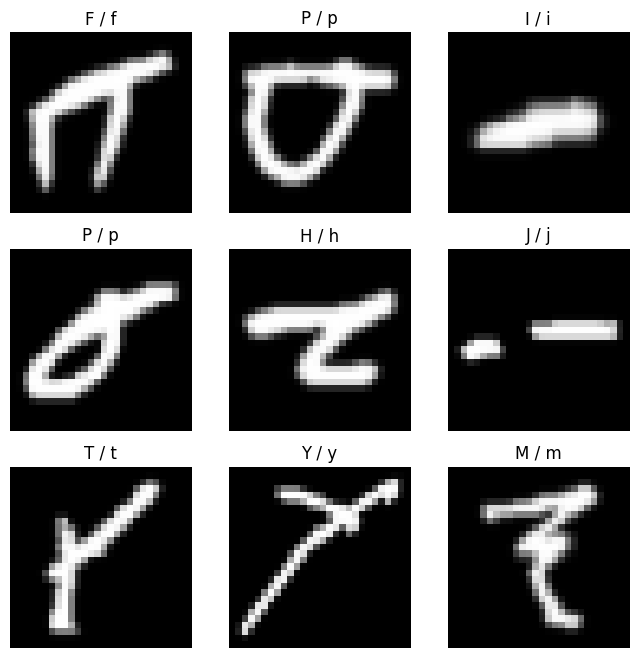

In [13]:
def get_mapping(num, with_type='letters'):
    """
    根据 mapping，由传入的 num 计算 UTF8 字符
    """
    if with_type == 'byclass':
        if num <= 9:
            return chr(num + 48)  # 数字
        elif num <= 35:
            return chr(num + 55)  # 大写字母
        else:
            return chr(num + 61)  # 小写字母
    elif with_type == 'letters':
        return chr(num + 64) + " / " + chr(num + 96)  # 大写/小写字母
    elif with_type == 'digits':
        return chr(num + 96)
    else:
        return num

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    print(label)
    figure.add_subplot(rows, cols, i)
    plt.title(get_mapping(label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [14]:
# 定义神经网络
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(  # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,  # 输入通道数
                out_channels=16,  # 输出通道数
                kernel_size=5,   # 卷积核大小
                stride=1,  #卷积步数
                padding=2,  # 如果想要 con2d 出来的图片长宽没有变化, 
                # padding=(kernel_size-1)/2 当 stride=1
            ),  # output shape (16, 28, 28)
            nn.ReLU(),  # activation
            nn.MaxPool2d(kernel_size=2),  # 在 2x2 空间里向下采样, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(  # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),  # output shape (32, 14, 14)
            nn.ReLU(),  # activation
            nn.MaxPool2d(2),  # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 37)  # 全连接层，A/Z,a/z一共37个类

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # 展平多维的卷积图成 (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output

In [15]:
cnn = CNN() # 创建CNN
# cnn = cnn.cuda() # 若有cuda环境，取消注释
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)  # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()  # the target label is not one-hotted
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):  # 每一步 loader 释放50个数据用来学习
        #b_x = b_x.cuda() # 若有cuda环境，取消注释
        #b_y = b_y.cuda() # 若有cuda环境，取消注释
        output = cnn(b_x)  # 输入一张图片进行神经网络训练
        loss = loss_func(output, b_y)  # 计算神经网络的预测值与实际的误差
        optimizer.zero_grad() #将所有优化的torch.Tensors的梯度设置为零
        loss.backward()  # 反向传播的梯度计算
        optimizer.step()  # 执行单个优化步骤
        if step % 50 == 0: # 我们每50步来查看一下神经网络训练的结果
            test_output = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            # 若有cuda环境，使用84行，注释82行
            # pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze()
            accuracy = float((pred_y == test_y).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data,
                  '| test accuracy: %.2f' % accuracy)

Epoch:  0 | train loss: 3.6255 | test accuracy: 0.01
Epoch:  0 | train loss: 1.3196 | test accuracy: 0.53
Epoch:  0 | train loss: 1.6737 | test accuracy: 0.57
Epoch:  0 | train loss: 0.8404 | test accuracy: 0.51
Epoch:  0 | train loss: 1.0761 | test accuracy: 0.79
Epoch:  0 | train loss: 0.5070 | test accuracy: 0.77
Epoch:  0 | train loss: 0.6220 | test accuracy: 0.77
Epoch:  0 | train loss: 0.4379 | test accuracy: 0.85
Epoch:  0 | train loss: 0.6436 | test accuracy: 0.83
Epoch:  0 | train loss: 0.4675 | test accuracy: 0.82
Epoch:  0 | train loss: 0.2157 | test accuracy: 0.88
Epoch:  0 | train loss: 0.5705 | test accuracy: 0.83
Epoch:  0 | train loss: 0.4886 | test accuracy: 0.82
Epoch:  0 | train loss: 0.3559 | test accuracy: 0.90
Epoch:  0 | train loss: 0.2750 | test accuracy: 0.88
Epoch:  0 | train loss: 0.2624 | test accuracy: 0.81
Epoch:  0 | train loss: 0.5587 | test accuracy: 0.82
Epoch:  0 | train loss: 0.2013 | test accuracy: 0.85
Epoch:  0 | train loss: 0.5812 | test accuracy

In [17]:
# test 神经网络
test_output = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.squeeze()
# 若有cuda环境，使用92行，注释90行
#pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze()
print(pred_y, 'prediction number')
print(test_y[:10], 'real number')
# save CNN
# 仅保存CNN参数，速度较快
# torch.save(cnn.state_dict(), './model/CNN_letter.pk')
# 保存CNN整个结构
#torch.save(cnn(), './model/CNN.pkl')

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) prediction number
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) real number
